Import libraries

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np

Set device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Load Fashion MNIST

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.3MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 174kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.10MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 24.7MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
class RealNVP(nn.Module):
  def __init__(self, num_layers):
    super(RealNVP, self).__init__()
    self.num_layers = num_layers
    self.prior = torch.distributions.MultivariateNormal(torch.zeros(28 * 28), torch.eye(28 * 28))
    self.coupling_layers = nn.ModuleList()
    self.permutation_layers = nn.ModuleList()
    for _ in range(num_layers):
      self.coupling_layers.append(CouplingLayer(28 * 28))
      self.permutation_layers.append(PermutationLayer(28 * 28))

  def forward(self, x):
    log_det_J = 0
    for coupling_layer, permutation_layer in zip(self.coupling_layers, self.permutation_layers):
      x, log_det = coupling_layer(x)
      log_det_J += log_det
      x = permutation_layer(x)
    return x, log_det_J

  def inverse(self, z):
    log_det_J = 0
    for coupling_layer, permutation_layer in zip(reversed(self.coupling_layers), reversed(self.permutation_layers)):
      z = permutation_layer.inverse(z)
      z, log_det = coupling_layer.inverse(z)
      log_det_J += log_det
    return z, log_det_J

  def log_prob(self, x):
    z, log_det_J = self.forward(x)
    log_pz = self.prior.log_prob(z)
    return log_pz + log_det_J

  def to(self, device):
    self.prior.loc = self.prior.loc.to(device)
    self.prior.covariance_matrix = self.prior.covariance_matrix.to(device)
    self.prior._unbroadcasted_scale_tril = self.prior._unbroadcasted_scale_tril.to(device)
    for layer in self.coupling_layers:
      layer.to(device)
    for layer in self.permutation_layers:
      layer.to(device)
    return super().to(device)

class CouplingLayer(nn.Module):
  def __init__(self, input_size):
    super(CouplingLayer, self).__init__()
    self.mask = (torch.arange(0, input_size) % 2).to(device)  # masking as in RealNVP paper
    self.s = nn.Sequential(
      nn.Linear(input_size, 1024),
      nn.LeakyReLU(),
      nn.Linear(1024, 1024),
      nn.LeakyReLU(),
      nn.Linear(1024, input_size),
      nn.Tanh()
      )
    self.t = nn.Sequential(
      nn.Linear(input_size, 1024),
      nn.LeakyReLU(),
      nn.Linear(1024, 1024),
      nn.LeakyReLU(),
      nn.Linear(1024, input_size),
      )

  def forward(self, x):
    x1 = x * self.mask
    s = self.s(x1) * (1 - self.mask)
    t = self.t(x1) * (1 - self.mask)
    z = x1 + (1 - self.mask) * (x * torch.exp(s) + t)
    log_det_J = s.sum(dim=1)
    return z, log_det_J

  def inverse(self, z):
    z1 = z * self.mask
    s = self.s(z1) * (1 - self.mask)
    t = self.t(z1) * (1 - self.mask)
    x = z1 + (1 - self.mask) * (z - t) * torch.exp(-s)
    log_det_J = -s.sum(dim=1)
    return x, log_det_J

class PermutationLayer(nn.Module):
  def __init__(self, input_size):
    super(PermutationLayer, self).__init__()
    permutation_indices = torch.randperm(input_size)
    permutation_matrix = torch.zeros(input_size, input_size)
    permutation_matrix[range(input_size), permutation_indices] = 1
    if torch.det(permutation_matrix) == -1:  # to ensure the permutation determinant is 1
      permutation_indices[0], permutation_indices[1] = permutation_indices[1], permutation_indices[0]
      permutation_matrix[range(input_size), permutation_indices] = 1

    self.permutation_matrix = nn.Parameter(permutation_matrix, requires_grad=False)

  def forward(self, x):
    return x @ self.permutation_matrix

  def inverse(self, y):
    return y @ torch.inverse(self.permutation_matrix)

create model and optimizer

In [42]:
model = RealNVP(12).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay = 1e-5)

In [43]:
# Training loop
EPOCHS = 20
train_losses = []
test_losses = []

for epoch in tqdm(range(EPOCHS)):
  model.train()
  total_train_loss = 0
  for x_train, _ in train_loader:
    x_train = x_train.view(x_train.size(0), -1).to(device)
    optimizer.zero_grad()
    loss = -model.log_prob(x_train).mean()
    loss.backward()
    optimizer.step()
    total_train_loss += loss.item()

  train_losses.append(total_train_loss / len(train_loader))

  model.eval()
  total_test_loss = 0
  with torch.no_grad():
    for x_test, _ in test_loader:
      x_test = x_test.view(x_test.size(0), -1).to(device)
      loss = -model.log_prob(x_test).mean()
      total_test_loss += loss.item()

  test_losses.append(total_test_loss / len(test_loader))
  print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Train Loss: -667.5048028888987, Test Loss: -937.0909493804737
Epoch 2, Train Loss: -1076.7607099781158, Test Loss: -1116.4450392024532
Epoch 3, Train Loss: -1218.999623898504, Test Loss: -1241.6890410405056
Epoch 4, Train Loss: -1306.9729929194013, Test Loss: -1295.5432354386446
Epoch 5, Train Loss: -1373.7831335006747, Test Loss: -1346.924469577279
Epoch 6, Train Loss: -1425.6263492803837, Test Loss: -1385.4418160019407
Epoch 7, Train Loss: -1463.9126996851678, Test Loss: -1415.9386631667994
Epoch 8, Train Loss: -1502.1176312737373, Test Loss: -1431.8633426739152
Epoch 9, Train Loss: -1532.6033169028601, Test Loss: -1479.0847712231289
Epoch 10, Train Loss: -1559.8583651219349, Test Loss: -1468.2582891184813
Epoch 11, Train Loss: -1584.581804938408, Test Loss: -1499.3824447340266
Epoch 12, Train Loss: -1607.10382457481, Test Loss: -1486.6270098838077
Epoch 13, Train Loss: -1626.6630398683203, Test Loss: -1519.9091960153762
Epoch 14, Train Loss: -1643.2508283342634, Test Loss: 

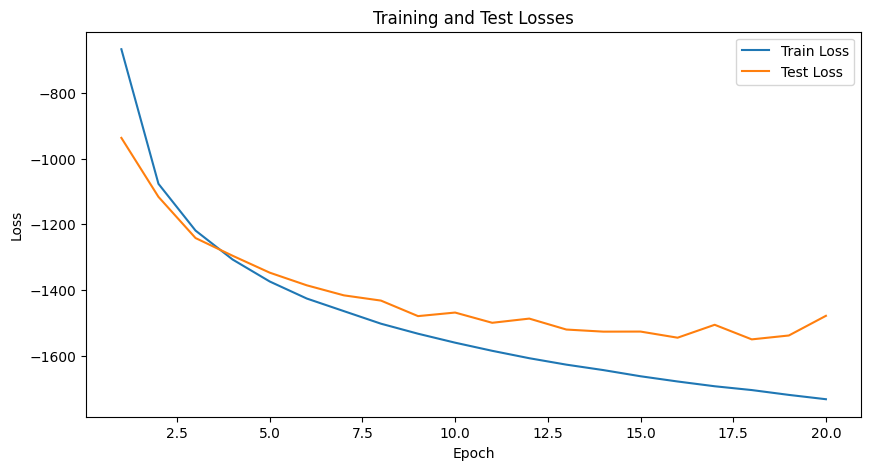

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Losses')
plt.show()

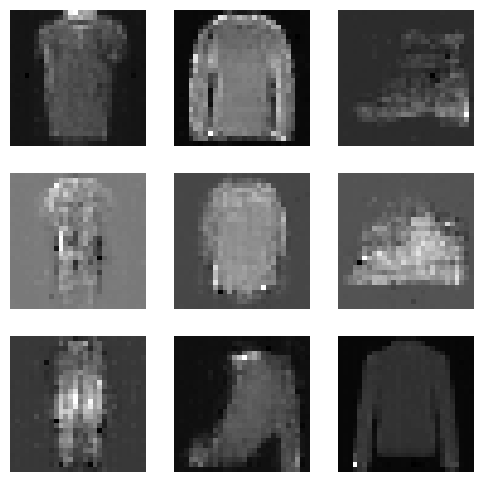

In [53]:
with torch.no_grad():
  z = torch.randn(9, model.prior.loc.shape[0]).to(device)
  samples, _ = model.inverse(z)

samples = samples.view(9, 28, 28)

fig, axs = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
  for j in range(3):
    axs[i, j].imshow(samples[i * 3 + j].cpu().numpy(), cmap='gray')
    axs[i, j].axis('off')
plt.show()


In [46]:
kmnist_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
kmnist_loader = DataLoader(kmnist_dataset, batch_size=64, shuffle=False)

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_dataset, batch_size=64, shuffle=False)

In [47]:
def calculate_log_prob(loader, model):
  log_probs = []
  model.eval()
  with torch.no_grad():
    for x, _  in loader:
      x = x.view(x.size(0), -1).to(device)
      log_prob = model.log_prob(x)
      log_probs.append(log_prob.cpu().numpy())
  return np.concatenate(log_probs)

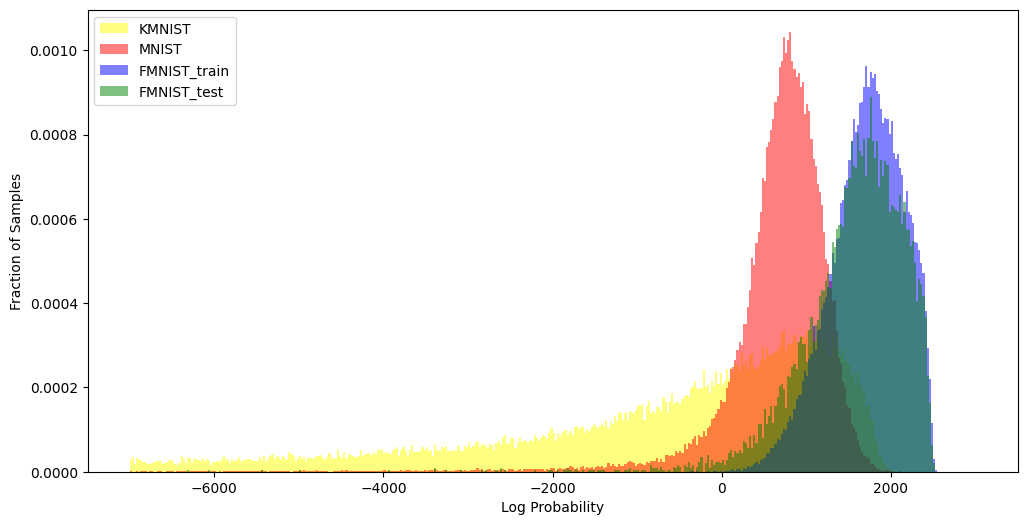

In [52]:
kmnist_log_probs = calculate_log_prob(kmnist_loader, model)
mnist_log_probs = calculate_log_prob(mnist_loader, model)
fmnist_train_log_probs = calculate_log_prob(train_loader, model)
fmnist_test_log_probs = calculate_log_prob(test_loader, model)

plt.figure(figsize=(12, 6))
lower_bound = -7000
upper_bound = 3000

plt.hist(kmnist_log_probs, bins=400, alpha=0.5, label='KMNIST', color='yellow', density=True, range=(lower_bound, upper_bound))
plt.hist(mnist_log_probs, bins=400, alpha=0.5, label='MNIST', color='red', density=True, range=(lower_bound, upper_bound))
plt.hist(fmnist_train_log_probs, bins=400, alpha=0.5, label='FMNIST_train', color='blue', density=True, range=(lower_bound, upper_bound))
plt.hist(fmnist_test_log_probs, bins=400, alpha=0.5, label='FMNIST_test', color='green', density=True, range=(lower_bound, upper_bound))

plt.xlabel('Log Probability')
plt.ylabel('Fraction of Samples')
plt.legend(loc='upper left')

plt.show()
